In [17]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hnn_core
from hnn_core import (jones_2009_model, simulate_dipole, pick_connection,
                      read_network_configuration, read_dipole, JoblibBackend)
from hnn_core.viz import plot_dipole
from scipy.stats import norm
import pickle
from scipy.interpolate import CubicSpline
from joblib import Parallel, delayed


In [33]:
tstop = 250
def run_net(net, tstop=250):
    with JoblibBackend(n_jobs=20):
        dpl = simulate_dipole(net, tstop=tstop, dt=0.025, n_trials=10)
    return net, dpl

fpath = '../data/network_configurations'

net_optimized = read_network_configuration(f'{fpath}/../opt_baseline_config_correlation_best.json')
net_inh = net_optimized.copy()
# # Dendritic Km
# for sec_name, sec in net_km.cell_types['L5_pyramidal']['cell_object'].sections.items():
#     if sec_name != 'soma':
#         sec.mechs['km']['gbar_km'] *= (10 ** -0.3)

# Inhibitory gain
conn_indices = pick_connection(net_inh, receptor=['gabab'])
for conn_idx in conn_indices:
    net_inh.connectivity[conn_idx]['nc_dict']['A_weight'] *= (10 ** -0.15)

net_configs = [net_optimized, net_inh]

res = [run_net(net) for net in net_configs]

Joblib will run 10 trial(s) in parallel by distributing trials over 20 jobs.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Building the NEURON model
Building the NEURON model
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soBuilding the NEURON model

Building the NEURON model
Loading custom mechanism files from /use

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON modelLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Building the NEURON modelBuilding th

In [34]:

# Load network and dipole into lists
dpl_list = [dpl for (net, dpl) in res]
net_list = [net for (net, dpl) in res]
times = res[0][1][0].times

# Resample target waveform
dipole_experimental = read_dipole('../data/L_Contra.txt')
baseline_cs = CubicSpline(dipole_experimental.times, dipole_experimental.data['agg'])
baseline_dpl = baseline_cs(times)

# THIS IS THE DEFAULT
biomarker_scale = 0.5
gauss = norm.pdf(times, loc=20, scale=200)

gauss = (gauss / np.max(gauss)) * (biomarker_scale - 1)
gauss += 1
biomarker_dpl = baseline_dpl * gauss


In [35]:
def _corr_evoked():
    pass

def set_params():
    pass

with open('../data/opt_baseline_object_correlation_best.pkl', 'rb') as file:
    opt_run = pickle.load(file)

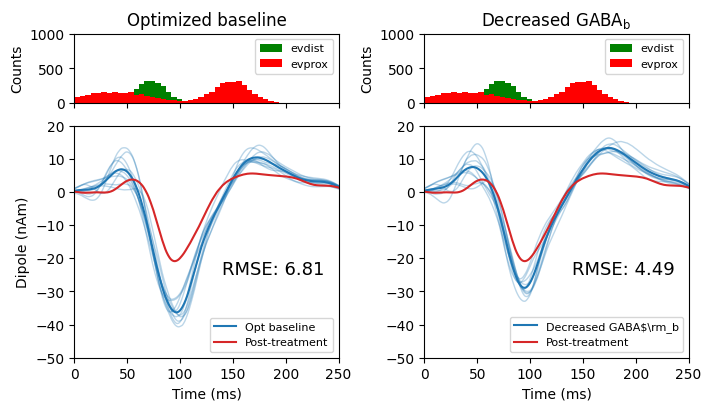

In [47]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(7, 4), height_ratios=(0.3, 1),
                         constrained_layout=True)

smooth_window = 40
scale_factor_list = [1000, 1000]
net_names = ['Optimized baseline', 'Decreased GABA$\\rm_b$']
sim_titles = ['Opt baseline', 'Decreased GABA$\\rm_b']
for col_idx in range(2):
    dpl_plot = [dpl_trial.copy().smooth(smooth_window).scale(scale_factor_list[col_idx]).data['agg'] for dpl_trial in dpl_list[col_idx]]

    net_list[col_idx].cell_response.plot_spikes_hist(ax=axes[0, col_idx], spike_types=['evprox', 'evdist'], show=False)
    axes[0, col_idx].set_ylim(0, 1000)
    axes[0, col_idx].set_title(net_names[col_idx])
    axes[0, col_idx].legend(fontsize=8)

    axes[1, col_idx].plot(times, np.array(dpl_plot).T, color='C0', alpha=0.3, linewidth=1)
    avg_dpl = np.mean(dpl_plot, axis=0)
    axes[1, col_idx].plot(times, avg_dpl, color='C0', label=sim_titles[col_idx])
    axes[1, col_idx].plot(times, biomarker_dpl, color='C3', label='Post-treatment')

    rmse = np.sqrt(np.mean((avg_dpl - biomarker_dpl) ** 2))
    axes[1, col_idx].set_ylim(-50, 20)
    axes[1, col_idx].set_xlabel('Time (ms)')
    axes[1, col_idx].text(140, -25, f'RMSE: {rmse:.2f}', fontsize=13)
    axes[1, col_idx].legend(loc='lower right', fontsize=8)

_ = axes[1, 0].set_ylabel('Dipole (nAm)')
plt.savefig('../figures/posttreatment_optimization_sequence.svg')


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

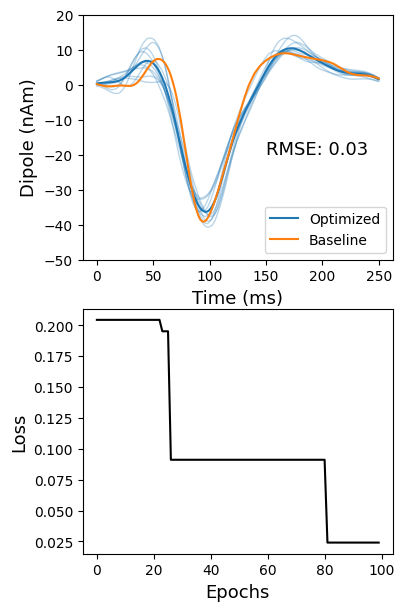

In [24]:
labelsize=13
ticksize = 10

plt.figure(figsize=(4,7))

dpl_plot = [dpl_trial.copy().smooth(smooth_window).scale(scale_factor_list[col_idx]).data['agg'] for dpl_trial in dpl_list[0]]

plt.subplot(2,1,1)
plt.plot(times, np.array(dpl_plot).T, color='C0', alpha=0.3, linewidth=1)
avg_dpl = np.mean(dpl_plot, axis=0)
plt.plot(times, avg_dpl, color='C0', label='Optimized')
plt.plot(times, baseline_dpl, color='C1', label='Baseline')

rmse = np.sqrt(np.sum((avg_dpl - baseline_dpl) ** 2)) / len(avg_dpl)
plt.ylim(-50, 20)
plt.xlabel('Time (ms)')
plt.text(150, -20, f'RMSE: {rmse:.2f}', fontsize=13)
plt.legend(loc='lower right', fontsize=10)

plt.xlabel('Time (ms)', fontsize=labelsize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

plt.subplot(2,1,2)
plt.plot(opt_run.obj_, color='k')
plt.xlabel('Epochs', fontsize=labelsize)
plt.ylabel('Loss', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)
